<a href="https://colab.research.google.com/github/koblitz/Caged_data/blob/main/caged_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A informação dos empregos formais no Brasil são fontes de inúmeras análises. Aqui pretendemos demonstrar uma forma de extração e apresentação desses dados. 
Para obter os dados faz-se necessário baixar as planilhas mês a mês no site do sistema do CAGED. Cada planilha tem um tamanho entre 8 e 22 MB. Portanto, o processo pode ser um pouco lento. A cada planilha lida voce poderá ver essa informação.
Criaremos inicialmente um DataFrame pandas e depois uma visualização simples dos dados.

Para facilitar o uso do mês em portugues, conforme é apresentado no CAGED, instalamos o 'language-pack pt_BR' no Colab.

In [ ]:
import os
!/usr/share/locales/install-language-pack pt_BR
!dpkg-reconfigure locales
os.kill(os.getpid(), 9)


In [ ]:
!pip install wget
import wget
from openpyxl import load_workbook
import datetime #import datetime
import pandas as pd
import os
import locale
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

 Indicamos o idioma para ser usado na máquina, incluindo seu uso pelo módulo datetime.

In [ ]:
locale.setlocale(locale.LC_ALL, 'pt_BR.ISO-8859-1')

'pt_BR.ISO-8859-1'

Criamos a lista das urls das planilhas que serão baixadas. A estrutura das urls diferem porque a partir de janeiro de 2020 o governo brasileiro passou a adotar o NOVO CAGED com um link diferente. Por isso foi preciso identificar duas listas separadas de urls.

In [ ]:
def range_month(dt_ini,dt_fim=None):
 if not dt_fim:
  dt_fim=datetime.datetime.now()
 lt_alltime=pd.date_range(datetime.datetime.strptime(dt_ini, "%m%Y") - datetime.timedelta(days=10),
                          dt_fim, freq='MS')
 t_lim=datetime.datetime.strptime('122019','%m%Y')
 lt_before=[i for i in lt_alltime if i <= t_lim]
 lt_after=[i for i in lt_alltime if i > t_lim]
 return lt_before,lt_after

Este código está adaptado apenas para os dados do NOVO CAGED, pois os antigo estava inoperante enquanto elaboramos esse script, incluindo o endereço do ftp.
Quando o site estiver fornecendo os dados, basta utilizar o return da função 'get_links', abaixo, que está marcado e desativar o que está operante. Ficará:

`return links_before+links_after`

`#return links_after`

In [ ]:
def get_links(dt_ini,dt_fim=None):
 lt_before,lt_after=range_month(dt_ini,dt_fim)
 links_before=['ftp://ftp.mtps.gov.br/pdet/caged/%s/%s/nacionais/4-tabelas.xls'\
          %(i.strftime('%Y'),i.strftime('%B').replace('ç','c')) for i in lt_before]
 links_after=['http://pdet.mte.gov.br/images/Novo_CAGED/%s/3-tabelas.xlsx'\
          %i.strftime('%b%Y').capitalize() for i in lt_after]
 #return links_before+links_after
 return links_after

Os formatos dt_ini e dt_fim a serem utilizados na função create_df, abaixo,  tem o mes com 2 dígitos e ano com 4. Ex: '102022' (com aspas).
Os códigos dos municípios podem ser pesquisados [aqui](https://www.ibge.gov.br/explica/codigos-dos-municipios.php).
Para essa referencia ser útil nota-se que é preciso remover o último número dado ao município. Por exemplo, nesse site, o código de Teresópolis é 3305802, portanto, ao criar a lista municípios a ser utilizada nesse script, coloca-se apenas 330580.
Abaixo os exemplos de uso da função:

`create_df ([330340, 330390,330580], '062021')`. O data frame virá com os dados desde junho de 2021 até o mes mais recente, dado que não há referencia ao mes e ano final da análise. São selecionados os municípios de Nova Friburgo, Petrópolis e Teresópolis.

`create_df ([330340, 330390,330580], '062021', '102022')`. O data frame virá com os dados desde junho de 2021 a outubro de 2022, selecionando os municípios de Nova Friburgo, Petrópolis e Teresópolis.

`create_df (330580, '062022', '102022)`. 
O data frame virá com os dados desde junho de 2021 a outubro de 2022, selecionando o município de  Teresópolis.

ERRO:`create_df (330580, 330390, '062022', '112022)`. Os códigos dos município precisam estar em uma lista. Apenas no caso de um único município é que se pode colocar fora da lista.

As planilhas são baixadas para o seu google drive, mas são removidas posteriormente na linha `os.remove(filename)`. Se quiser preservar as planilhas no drive, apenas comente essa linha.


In [ ]:
def create_df(municipios,dt_ini,dt_fim=None):
 sheet_nameN='Tabela 3'
 df1=pd.DataFrame(columns=['municipio','admissoes', 'desligamentos', 'saldo', 'var_relativa', 'mes_ano', 'mes_anots'])
 for address in get_links(dt_ini,dt_fim):
  filename="%s.xlsx"%address.split('/')[5]
  try:
   wget.download(address, filename)
   #while not os.path.exists("%s.xlsx"%dt):
   # time.sleep(10)
   #teresopolis=330580
   df= load_workbook(filename=filename, data_only=True)
   ws=df[sheet_nameN]
   wd=pd.DataFrame(ws.values)
   if type(municipios)!=list:
     municipios=[municipios]
   for muni in municipios:
    n=len(df1)+1
    df1.loc[n,'municipio']=wd.loc[wd.loc[:,2]==muni,3].values[0]
    df1.loc[n,'saldo']=wd.loc[wd.loc[:,2]==muni,6].values[0]
    df1.loc[n,'admissoes']=wd.loc[wd.loc[:,2]==muni,4].values[0]
    df1.loc[n,'desligamentos']=wd.loc[wd.loc[:,2]==muni,5].values[0]
    df1.loc[n,'var_relativa']=wd.loc[wd.loc[:,2]==muni,7].values[0]
    df1.loc[n,'mes_ano']=filename[:7]
    df1.loc[n,'mes_anots']=datetime.datetime.strptime(filename[:7], "%b%Y")
   os.remove(filename)
   print ('\r Os dados da planilha de %s já foram extraídos do CAGED'%filename)
  except:
   print ('\r %s não está disponível no sistema CAGED'%filename)
   os.remove(filename)
 return df1

Selcionamos os município de Petrópolis, Nova Frburgo e Teresópolis para essa análise desde o início do novo CAGED.

In [ ]:
municipios=[330340, 330390,330580]

In [ ]:
df1=create_df(municipios,'012020')

In [ ]:
df1

,municipio,saldo,ano,mes,mes_ano,mes_anots
1,Rj-Nova Friburgo,-97,2020,Jan,Jan2020,2020-01-01
2,Rj-Petropolis,-177,2020,Jan,Jan2020,2020-01-01
3,Rj-Teresopolis,43,2020,Jan,Jan2020,2020-01-01
4,Rj-Nova Friburgo,220,2020,Fev,Fev2020,2020-02-01
5,Rj-Petropolis,300,2020,Fev,Fev2020,2020-02-01
...,...,...,...,...,...,...
98,Rj-Petropolis,396,2022,Set,Set2022,2022-09-01
99,Rj-Teresopolis,33,2022,Set,Set2022,2022-09-01
100,Rj-Nova Friburgo,103,2022,Out,Out2022,2022-10-01
101,Rj-Petropolis,203,2022,Out,Out2022,2022-10-01


Para fazer o download do dataframe df1 que contém toda a informação obtida:

In [ ]:
from google.colab import files
df1.to_csv('df1.csv')
files.download("df1.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df1

,municipio,saldo,ano,mes,mes_ano,mes_anots
1,Rj-Nova Friburgo,-97,2020,Jan,Jan2020,2020-01-01
2,Rj-Petropolis,-177,2020,Jan,Jan2020,2020-01-01
3,Rj-Teresopolis,43,2020,Jan,Jan2020,2020-01-01
4,Rj-Nova Friburgo,220,2020,Fev,Fev2020,2020-02-01
5,Rj-Petropolis,300,2020,Fev,Fev2020,2020-02-01
...,...,...,...,...,...,...
98,Rj-Petropolis,396,2022,Set,Set2022,2022-09-01
99,Rj-Teresopolis,33,2022,Set,Set2022,2022-09-01
100,Rj-Nova Friburgo,103,2022,Out,Out2022,2022-10-01
101,Rj-Petropolis,203,2022,Out,Out2022,2022-10-01


Uma opção de visualização

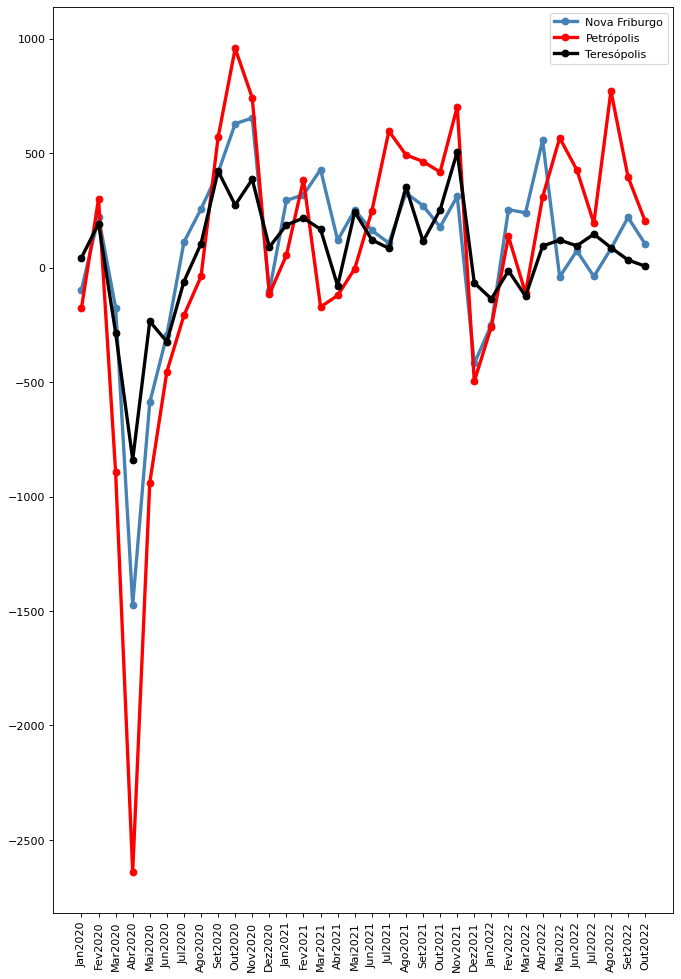

In [ ]:
figure(figsize=(10, 15), dpi=80)
col1 = 'steelblue'
d1=df1.loc[df1.municipio=='Rj-Nova Friburgo']
col2 = 'red'
d2=df1.loc[df1.municipio=='Rj-Petropolis']
col3='black'
d3=df1.loc[df1.municipio=='Rj-Teresopolis']
plt.plot(d1.mes_ano, d1.saldo, color=col1, marker='o', linewidth=3,
         label='Nova Friburgo')
plt.xticks(rotation=90)
plt.plot(d2.mes_ano, d2.saldo, color=col2, marker='o', linewidth=3,
         label='Petrópolis')
plt.plot(d3.mes_ano, d3.saldo, color=col3, marker='o', linewidth=3,
         label='Teresópolis')
plt.legend()#loc="upper left")

Bom trabalho com suas análises! 